In [1]:
import gym
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import time

from collections import deque
from agent import Agent, FloatTensor
from replay_buffer import ReplayMemory, Transition
from  torch.autograd import Variable

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device = torch.device("cuda" if use_cuda else "cpu")

BATCH_SIZE = 64  
TAU = 0.005 # 1e-3   # for soft update of target parameters
gamma = 0.99
LEARNING_RATE = 0.01 ##  0.001
TARGET_UPDATE = 10

num_episodes = 100000
print_every = 10
hidden_dim = 16 ## 64 ## 16
min_eps = 0.01
max_eps_episode = 50

env = gym.make('MountainCar-v0')
## env = gym.wrappers.Monitor(env, directory="monitors", force=True)
        
space_dim =  env.observation_space.shape[0] # n_spaces
action_dim = env.action_space.n # n_actions  
print('input_dim: ', space_dim, ', output_dim: ', action_dim, ', hidden_dim: ', hidden_dim)

threshold = env.spec.reward_threshold
print('threshold: ', threshold)

agent = Agent(space_dim, action_dim, hidden_dim, lr = LEARNING_RATE, device=device)

    
def epsilon_annealing(i_epsiode, max_episode, min_eps: float):
    ##  if i_epsiode --> max_episode, ret_eps --> min_eps
    ##  if i_epsiode --> 1, ret_eps --> 1  
    slope = (min_eps - 1.0) / max_episode
    ret_eps = max(slope * i_epsiode + 1.0, min_eps)
    return ret_eps        

def save(directory, filename):
    torch.save(agent.q_local.state_dict(), '%s/%s_local.pth' % (directory, filename))
    torch.save(agent.q_target.state_dict(), '%s/%s_target.pth' % (directory, filename))


input_dim:  2 , output_dim:  3 , hidden_dim:  16
threshold:  -110.0


In [2]:
def run_episode(env, agent, eps):
    """Play an epsiode and train

    Args:
        env (gym.Env): gym environment (CartPole-v0)
        agent (Agent): agent will train and get action        
        eps (float): eps-greedy for exploration

    Returns:
        int: reward earned in this episode
    """
    state = env.reset()
    done = False
    total_reward = 0
    

    while not done:

        action = agent.get_action(FloatTensor([state]) , eps)
        
        next_state, reward, done, _ = env.step(action.item())

        total_reward += reward

        if done:
            reward = -1
                    
        # Store the transition in memory
        agent.replay_memory.push(
                (FloatTensor([state]), 
                 action, # action is already a tensor
                 FloatTensor([reward]), 
                 FloatTensor([next_state]), 
                 FloatTensor([done])))
                 

        if len(agent.replay_memory) > BATCH_SIZE:

            batch = agent.replay_memory.sample(BATCH_SIZE)
            
            agent.learn(batch, gamma)

        state = next_state


    return total_reward


In [3]:
def train():    

    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []    
    
    time_start = time.time()

    for i_episode in range(num_episodes):
        eps = epsilon_annealing(i_episode, max_eps_episode, min_eps)
        score = run_episode(env, agent, eps)

        scores_deque.append(score)
        scores_array.append(score)
        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)

        dt = (int)(time.time() - time_start)
            
        if i_episode % print_every == 0 and i_episode > 0:
            print('Episode: {:5} Score: {:5}  Avg.Score: {:.2f}, eps-greedy: {:5.3f} Time: {:02}:{:02}:{:02}'.\
                    format(i_episode, score, avg_score, eps, dt//3600, dt%3600//60, dt%60))
            
        if len(scores_deque) == 100 and  avg_score >= threshold: 
                print('\n Environment solved in {:d} episodes!\tAverage Score: {:.2f}'. \
                    format(i_episode, np.mean(scores_deque)))
                break
                        
        if i_episode % TARGET_UPDATE == 0:
            agent.q_target.load_state_dict(agent.q_local.state_dict()) 
    
    return scores_array, avg_scores_array

scores, avg_scores = train()

Episode:    10 Score: -200.0  Avg.Score: -200.00, eps-greedy: 0.802 Time: 00:00:35
Episode:    20 Score: -200.0  Avg.Score: -200.00, eps-greedy: 0.604 Time: 00:01:10
Episode:    30 Score: -200.0  Avg.Score: -200.00, eps-greedy: 0.406 Time: 00:01:54
Episode:    40 Score: -200.0  Avg.Score: -200.00, eps-greedy: 0.208 Time: 00:02:47
Episode:    50 Score: -200.0  Avg.Score: -200.00, eps-greedy: 0.010 Time: 00:03:33
Episode:    60 Score: -200.0  Avg.Score: -200.00, eps-greedy: 0.010 Time: 00:04:20
Episode:    70 Score: -200.0  Avg.Score: -200.00, eps-greedy: 0.010 Time: 00:05:07
Episode:    80 Score: -200.0  Avg.Score: -200.00, eps-greedy: 0.010 Time: 00:05:51
Episode:    90 Score: -200.0  Avg.Score: -200.00, eps-greedy: 0.010 Time: 00:06:37
Episode:   100 Score: -200.0  Avg.Score: -200.00, eps-greedy: 0.010 Time: 00:07:22
Episode:   110 Score: -200.0  Avg.Score: -200.00, eps-greedy: 0.010 Time: 00:08:09
Episode:   120 Score: -200.0  Avg.Score: -200.00, eps-greedy: 0.010 Time: 00:09:18
Epis

Episode:   990 Score: -148.0  Avg.Score: -178.99, eps-greedy: 0.010 Time: 01:10:04
Episode:  1000 Score: -105.0  Avg.Score: -178.88, eps-greedy: 0.010 Time: 01:10:40
Episode:  1010 Score: -200.0  Avg.Score: -175.99, eps-greedy: 0.010 Time: 01:11:12
Episode:  1020 Score: -200.0  Avg.Score: -172.18, eps-greedy: 0.010 Time: 01:11:44
Episode:  1030 Score: -200.0  Avg.Score: -171.11, eps-greedy: 0.010 Time: 01:12:19
Episode:  1040 Score: -180.0  Avg.Score: -168.84, eps-greedy: 0.010 Time: 01:12:51
Episode:  1050 Score: -140.0  Avg.Score: -167.91, eps-greedy: 0.010 Time: 01:13:23
Episode:  1060 Score: -118.0  Avg.Score: -164.05, eps-greedy: 0.010 Time: 01:13:52
Episode:  1070 Score: -140.0  Avg.Score: -165.69, eps-greedy: 0.010 Time: 01:14:23
Episode:  1080 Score: -112.0  Avg.Score: -163.31, eps-greedy: 0.010 Time: 01:14:52
Episode:  1090 Score: -159.0  Avg.Score: -166.50, eps-greedy: 0.010 Time: 01:15:27
Episode:  1100 Score: -200.0  Avg.Score: -163.93, eps-greedy: 0.010 Time: 01:15:58
Epis

length of scores:  1835 , len of avg_scores:  1835


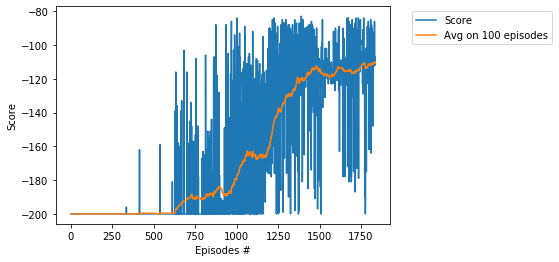

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [5]:
save('dir_chk', 'MountainCar')